# Journey (ML project lifecycle)

The journey consists of the following essential steps:

- **Scope**: Understand the project scope and business needs.
- **Data**: Understand the given data by conducting exploration data analysis (EDA)
  - Explore the dependent variable (target).
  - Explore the independent variables (features).
- **Modeling**: Build a proof of concept solution (PoC)
  - Select and train model.
  - Perform error analysis.
- **Deployment**: Deploy the PoC solution
  - Deploy model or models into production using FastAPI.
  - Monitor & maintain production system.

## Scope: Project Overview

- At Gorgias, we handle merchant customer tickets and provide a software platform that allows the tagging of tickets with the customer contact reason. 

- Each client has a **unique set of contact reasons**, making building a flexible and adaptable classification system essential.

- Automating the classification of these tickets based on merchant-specific contact reasons can significantly improve efficiency and enhance customer support.

- This project aims to develop a machine-learning solution to automate the classification of merchant customer tickets based on their contact reasons. 

- Please bear in mind that the final solution would handle about 250K tickets on a daily basis with an expected response time of around 200ms.

## Data: Exploration data analysis (EDA)

In [2]:
# import necessary libs

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS

%config InlineBackend.figure_format='retina'
%matplotlib inline

## Data info
- **account_id**: str, Unique merchant ID.
- **ticket_id**: str, Unique ticket ID.
- **raw_body**: str, Hashed representation of the received message.
- **channel**: str, Channel from which the message was received (in this case, emails).
- **unix_timestamp**: float, Timestamp indicating when the ticket was created.
- **contact_reason**: str, the contact reason label associated with the message.
- **processed_body**: str, Hashed representation of the message after processing.
- **email_sentence_embeddings**: str, JSON string format containing a dictionary of hashed extracted sentences from the email and their embeddings.

In [4]:
df = pd.read_parquet("data/classification_dataset")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56172 entries, 0 to 56171
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   account_id                 56172 non-null  object 
 1   ticket_id                  56172 non-null  object 
 2   raw_body                   56172 non-null  int64  
 3   channel                    56172 non-null  object 
 4   unix_timestamp             56172 non-null  float64
 5   contact_reason             56172 non-null  object 
 6   processed_body             56172 non-null  int64  
 7   email_sentence_embeddings  50719 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.4+ MB


## Contact reason (target) variable info

In [6]:
df.contact_reason.unique().shape[0]

1776

In [7]:
client_agg = df.groupby("account_id")
client_agg.size().shape[0]

67

There are **1776** unique labels associated with the email messages distributed across **67** unique merchants that are presented in the data

In [8]:

client_agg_cnt = client_agg.contact_reason.apply(lambda x: x.unique().shape[0]) \
                           .to_frame("#_contact_reasons_per_client") \
                           .sort_values("#_contact_reasons_per_client")

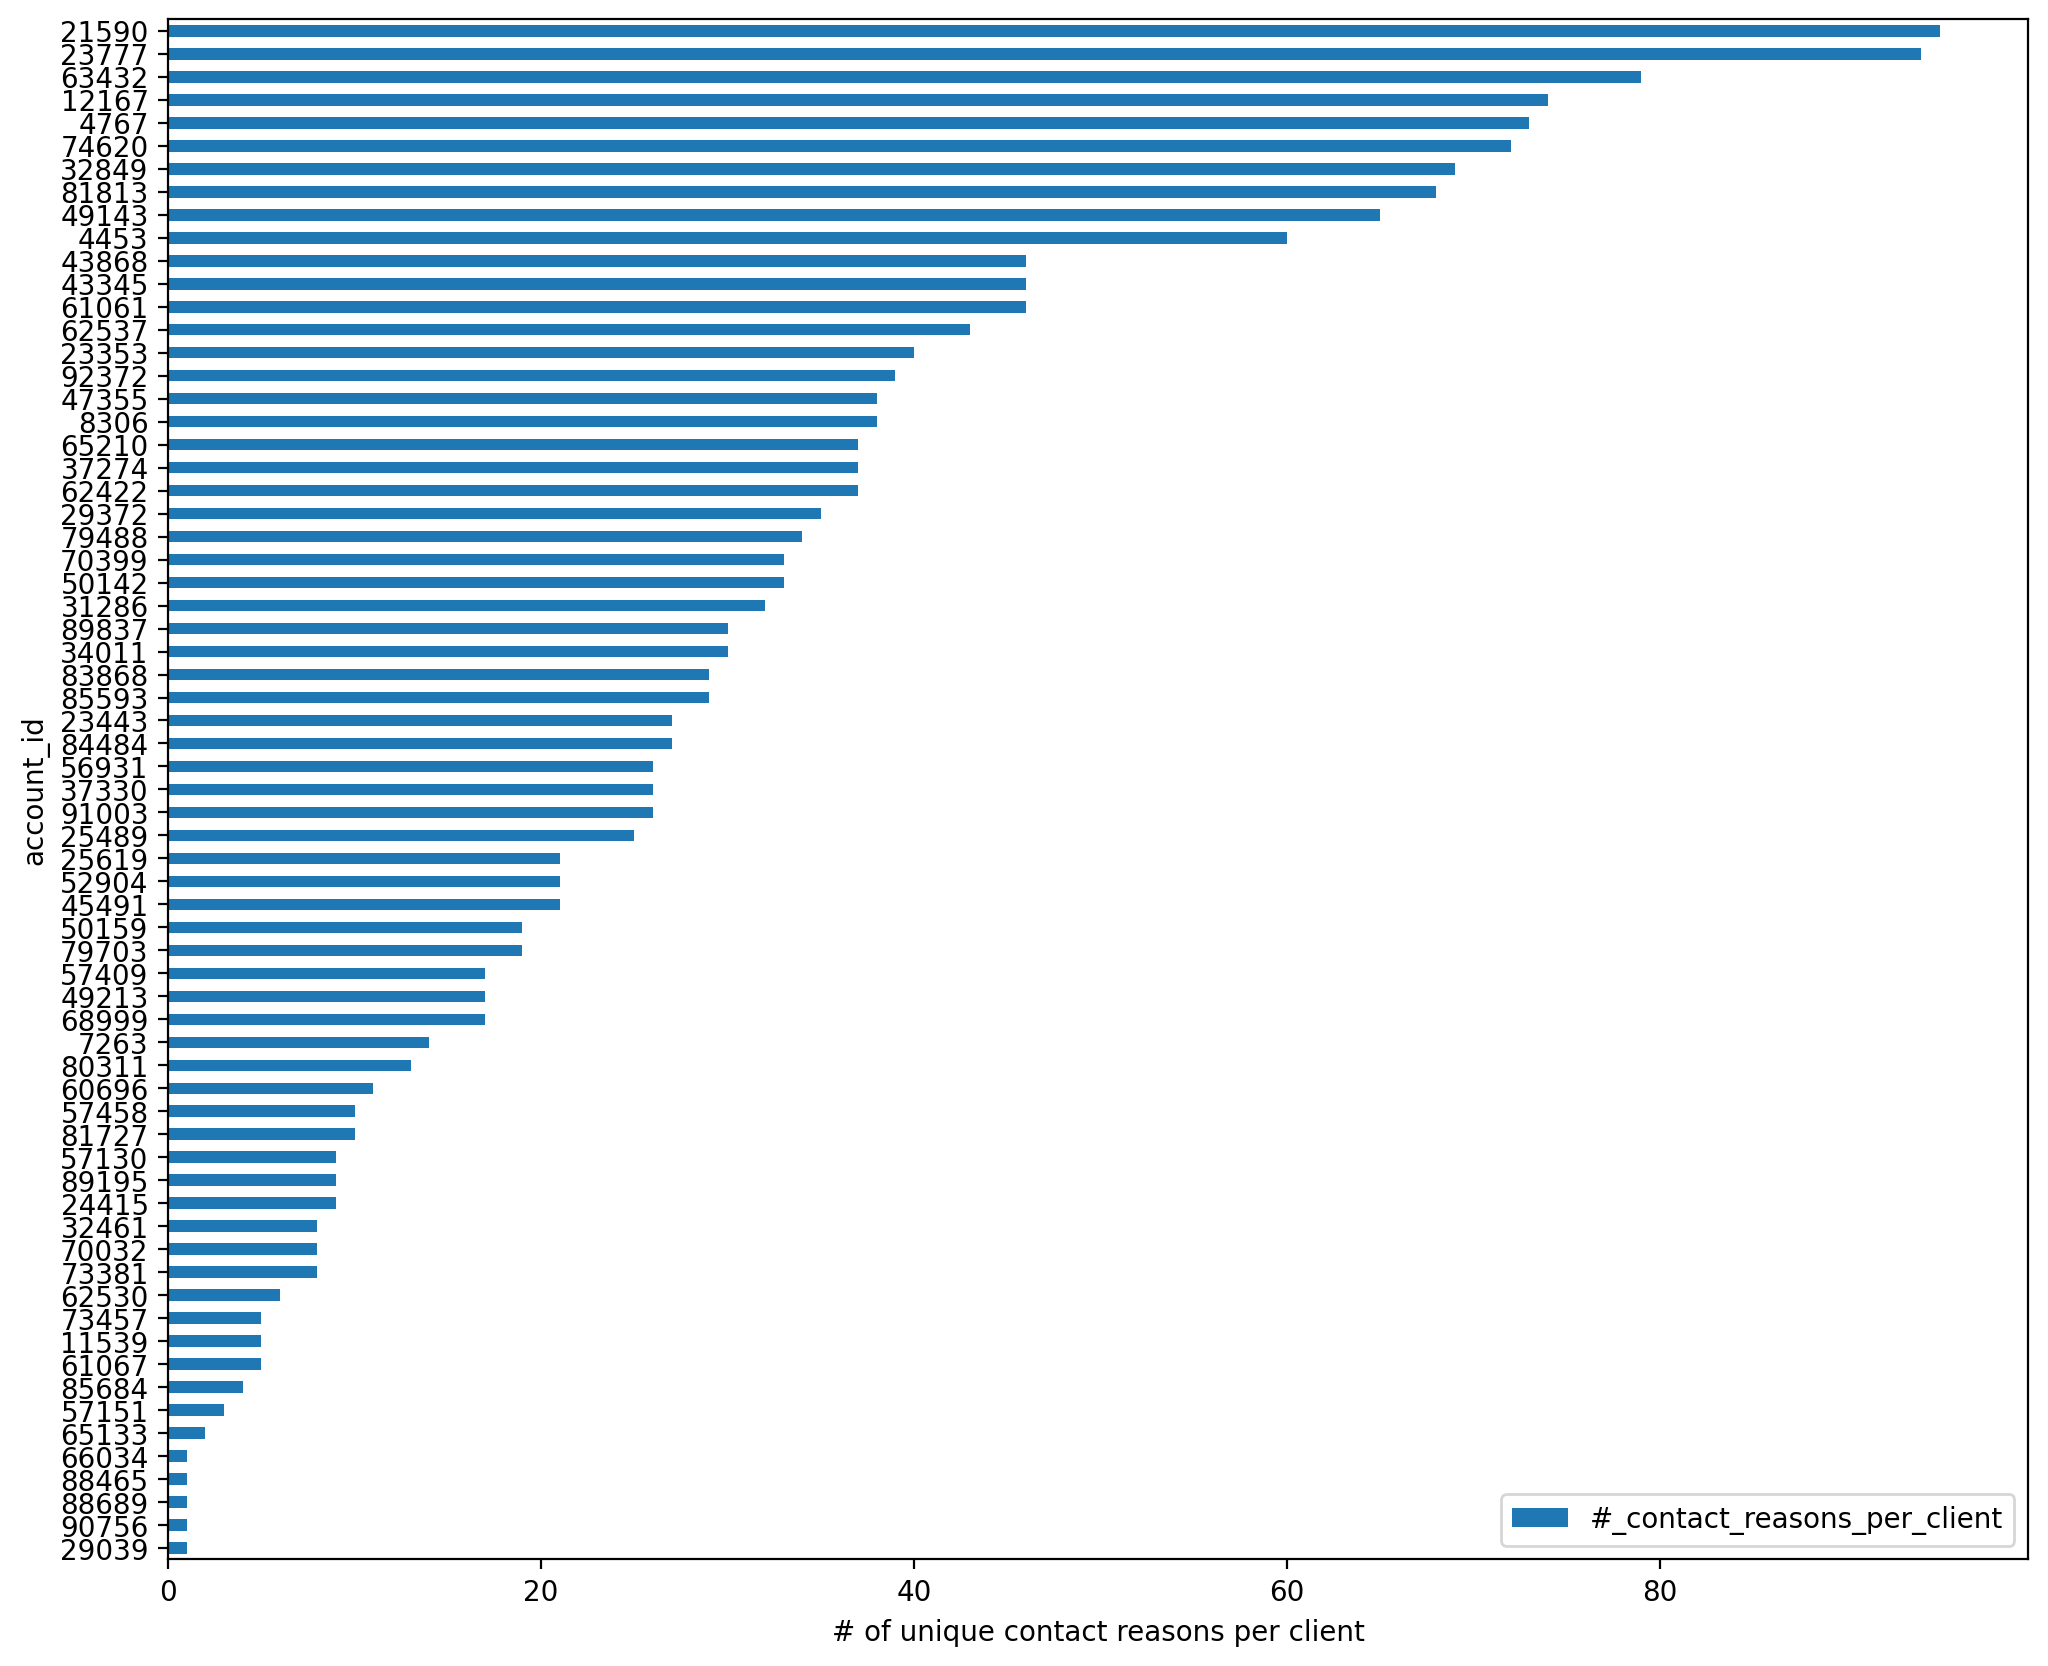

In [9]:
client_agg_cnt.plot(kind='barh', xlabel="# of unique contact reasons per client", figsize=(12, 10))
plt.show()

The figure shows the number of unique contact reasons per merchant. The distribution is skewed where bottom list of merchants have very few number of unique labels.

In [10]:
client_agg_cnt.head(10)

#_contact_reasons_per_client
account_id                              
29039                                  1
90756                                  1
88689                                  1
88465                                  1
66034                                  1
65133                                  2
57151                                  3
85684                                  4
61067                                  5
11539                                  5

The following merchants *29039*, *90756*, *88689*, *88465*, *66034* have only one contact reason. This needs to be considered in a PoC.

In [11]:
client_agg_set = client_agg.contact_reason.apply(lambda x: set(x))

In [12]:
top_client_ids = client_agg_cnt.tail(10).index.tolist()

In [13]:
all_client_ids = client_agg_cnt.index.tolist()
common_labels = set()

for account_id1 in all_client_ids:
    for account_id2 in all_client_ids:
        if account_id1 != account_id2:
            overlap_set = client_agg_set[account_id1].intersection(client_agg_set[account_id2])
            n_overlaps = len(overlap_set)
            if n_overlaps > 0:
                common_labels = common_labels.union(overlap_set)
                # print(f"There are {n_overlaps} overlaps in labels for merchants {account_id1} and {account_id2}")
                # print(overlap_set)
                # print("-----")

len(common_labels)

67

In [14]:
list(common_labels)[:10]

['"Product Advice"',
 '"Recycling"',
 '"Other::Wholesale"',
 '"Shipping::Tracking"',
 '"Product Question"',
 '"Subscription::Cancel"',
 '"Order::Wrong Item"',
 '"Shipping::Lost in Transit"',
 '"Order Status"',
 '"Order::Cancel::Not Shipped"']

From the description we have that each client has a **unique set of contact reasons**, however some of the merchants share **67** out of **1776** contact reasons such as "Other", "Cancel order" and "Social Media".

In [15]:
client_agg_list = client_agg.contact_reason.apply(lambda x: x.tolist())

In [16]:
wc = WordCloud(stopwords=STOPWORDS, max_words=100, width=800, height=400)

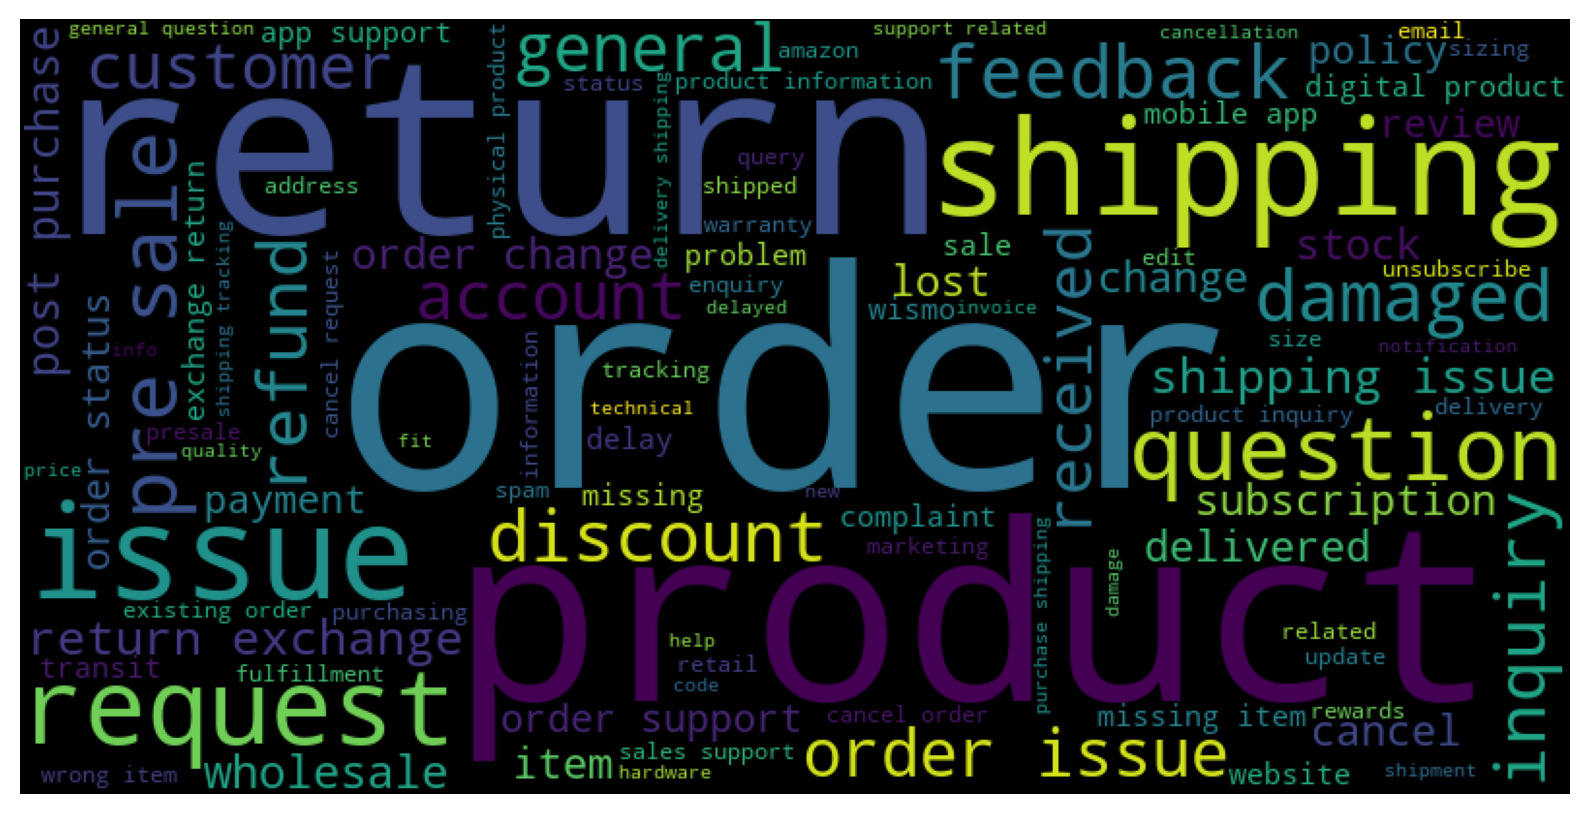

In [17]:
plt.figure(figsize=(10, 6))
contact_reasons = np.concatenate([l for l in client_agg_list.values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.imshow(wc)
plt.show()

WordCloud helps better understand the general overview of the contact reason labels per client. As I might observe from the figure that the majority of contact reasons are related to **shipping**, **order** and **return** of a **product**.

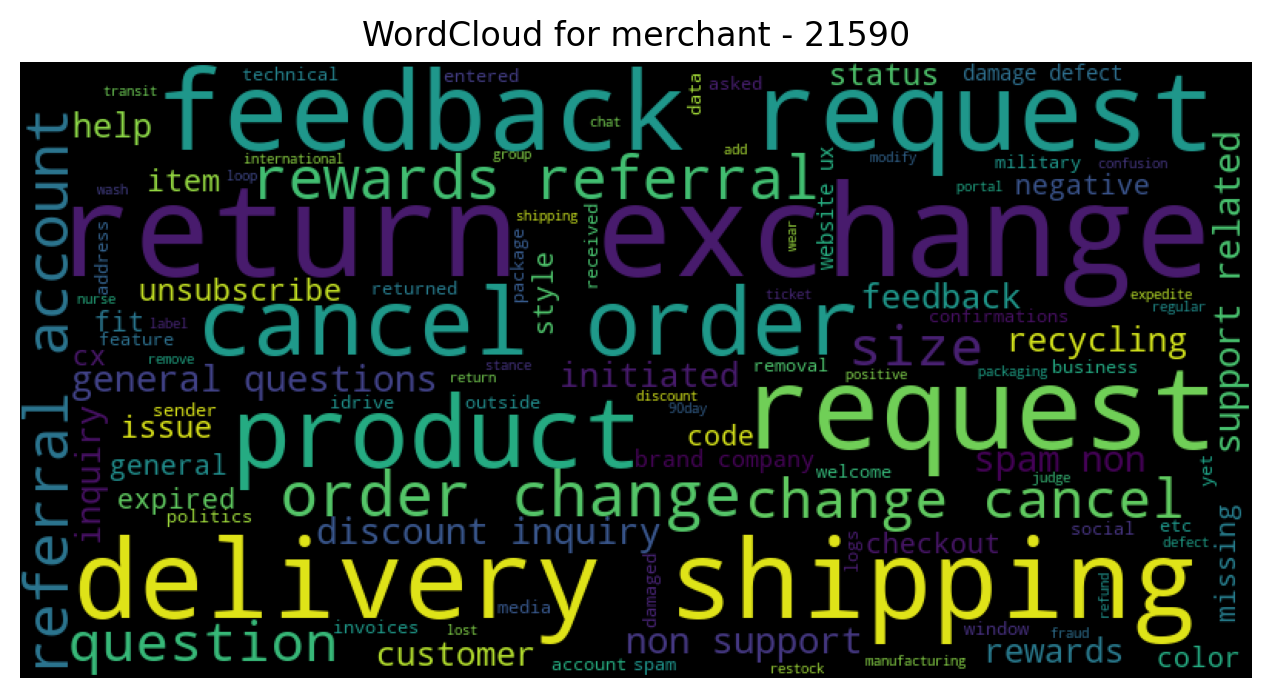

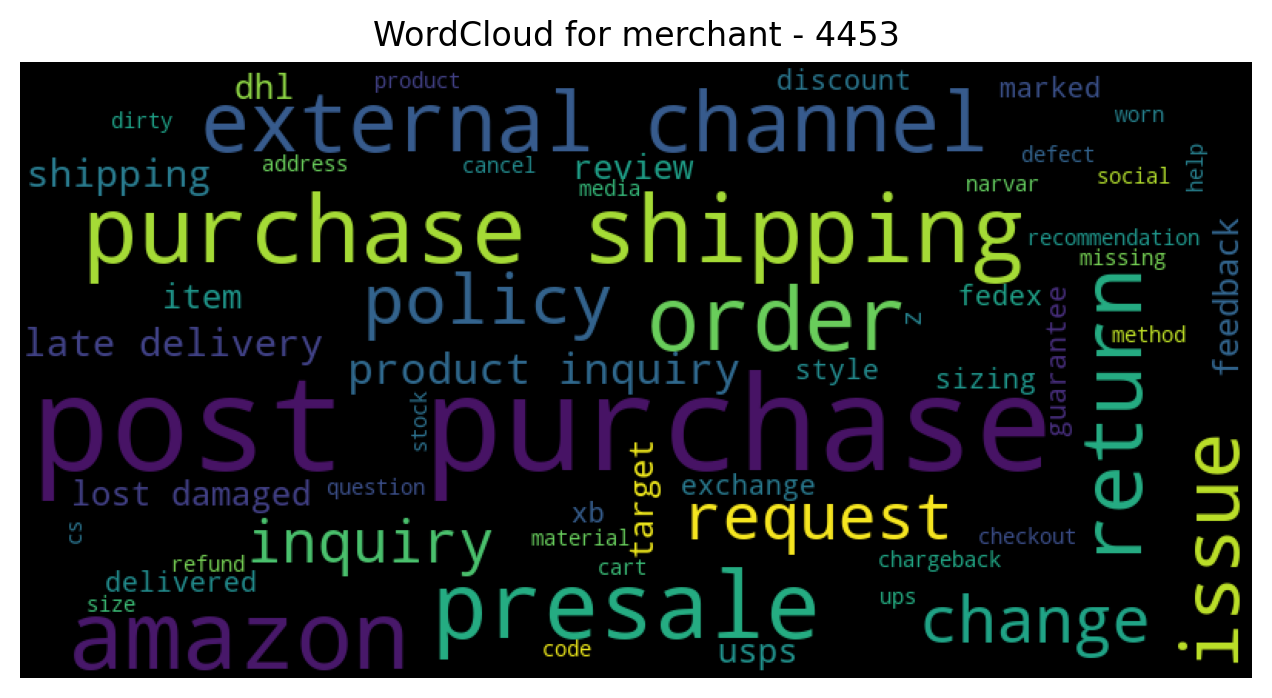

In [19]:
plt.figure(figsize=(8, 4))
contact_reasons = np.concatenate([l for l in client_agg_list[client_agg_list.index == top_client_ids[-1]].values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.title(f"WordCloud for merchant - {top_client_ids[-1]}")
plt.imshow(wc)
plt.show()

plt.figure(figsize=(8, 4))
contact_reasons = np.concatenate([l for l in client_agg_list[client_agg_list.index == top_client_ids[0]].values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.title(f"WordCloud for merchant - {top_client_ids[0]}")
plt.imshow(wc)
plt.show()

WordClouds with unique set of contact reasons for the top first and 10th merchants. 

In [20]:
client_agg_ticket_cnt = client_agg.size().to_frame("#_tickets_per_client")

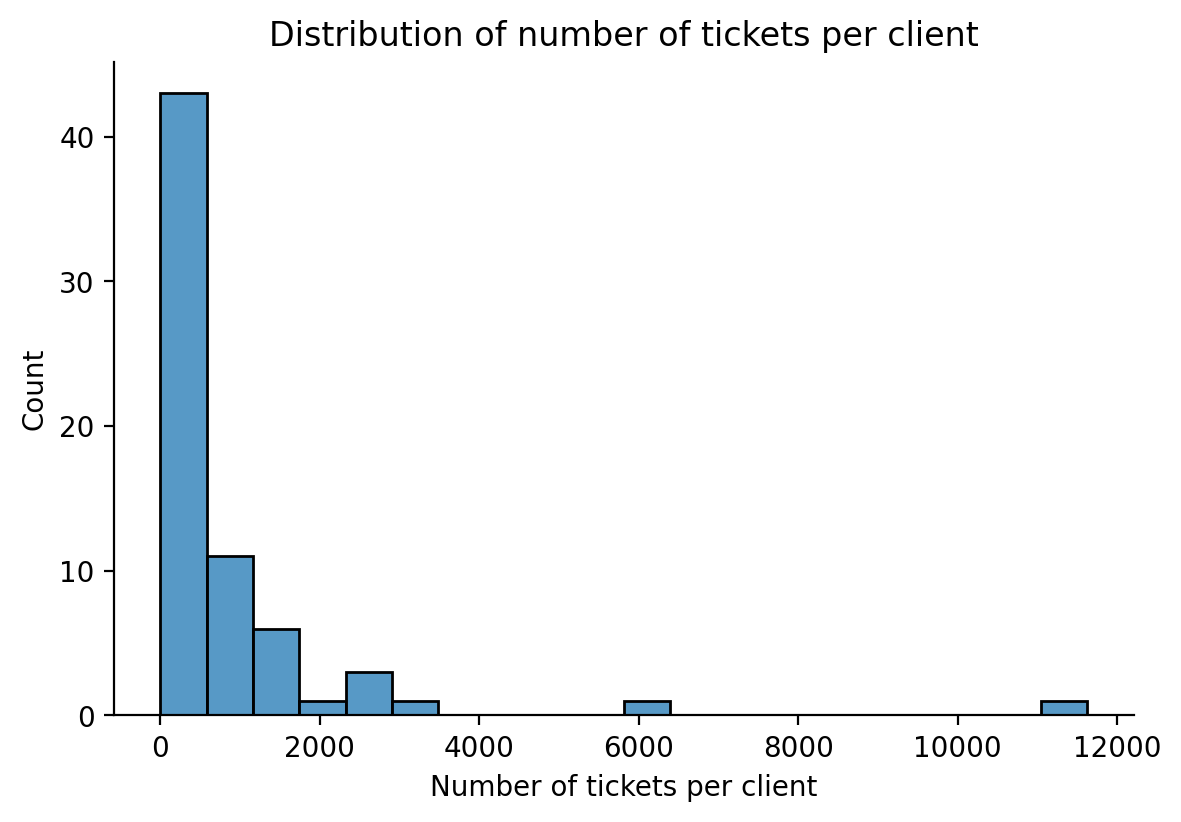

In [21]:
sns.displot(data=client_agg_ticket_cnt, x="#_tickets_per_client", bins=20, aspect=1.5, height=4)
plt.xlabel("Number of tickets per client")
plt.title("Distribution of number of tickets per client")
plt.show()

The number of tickets per client is also skewed so it needs to be considered in a PoC as well.

In [22]:
client_label_agg = df.groupby(["account_id", "contact_reason"])

In [23]:
client_label_agg_cnt = client_label_agg.size() \
                                       .to_frame("num_tickets") \
                                       .reset_index() \
                                       .sort_values(["account_id", "num_tickets"], ascending=[True, False])

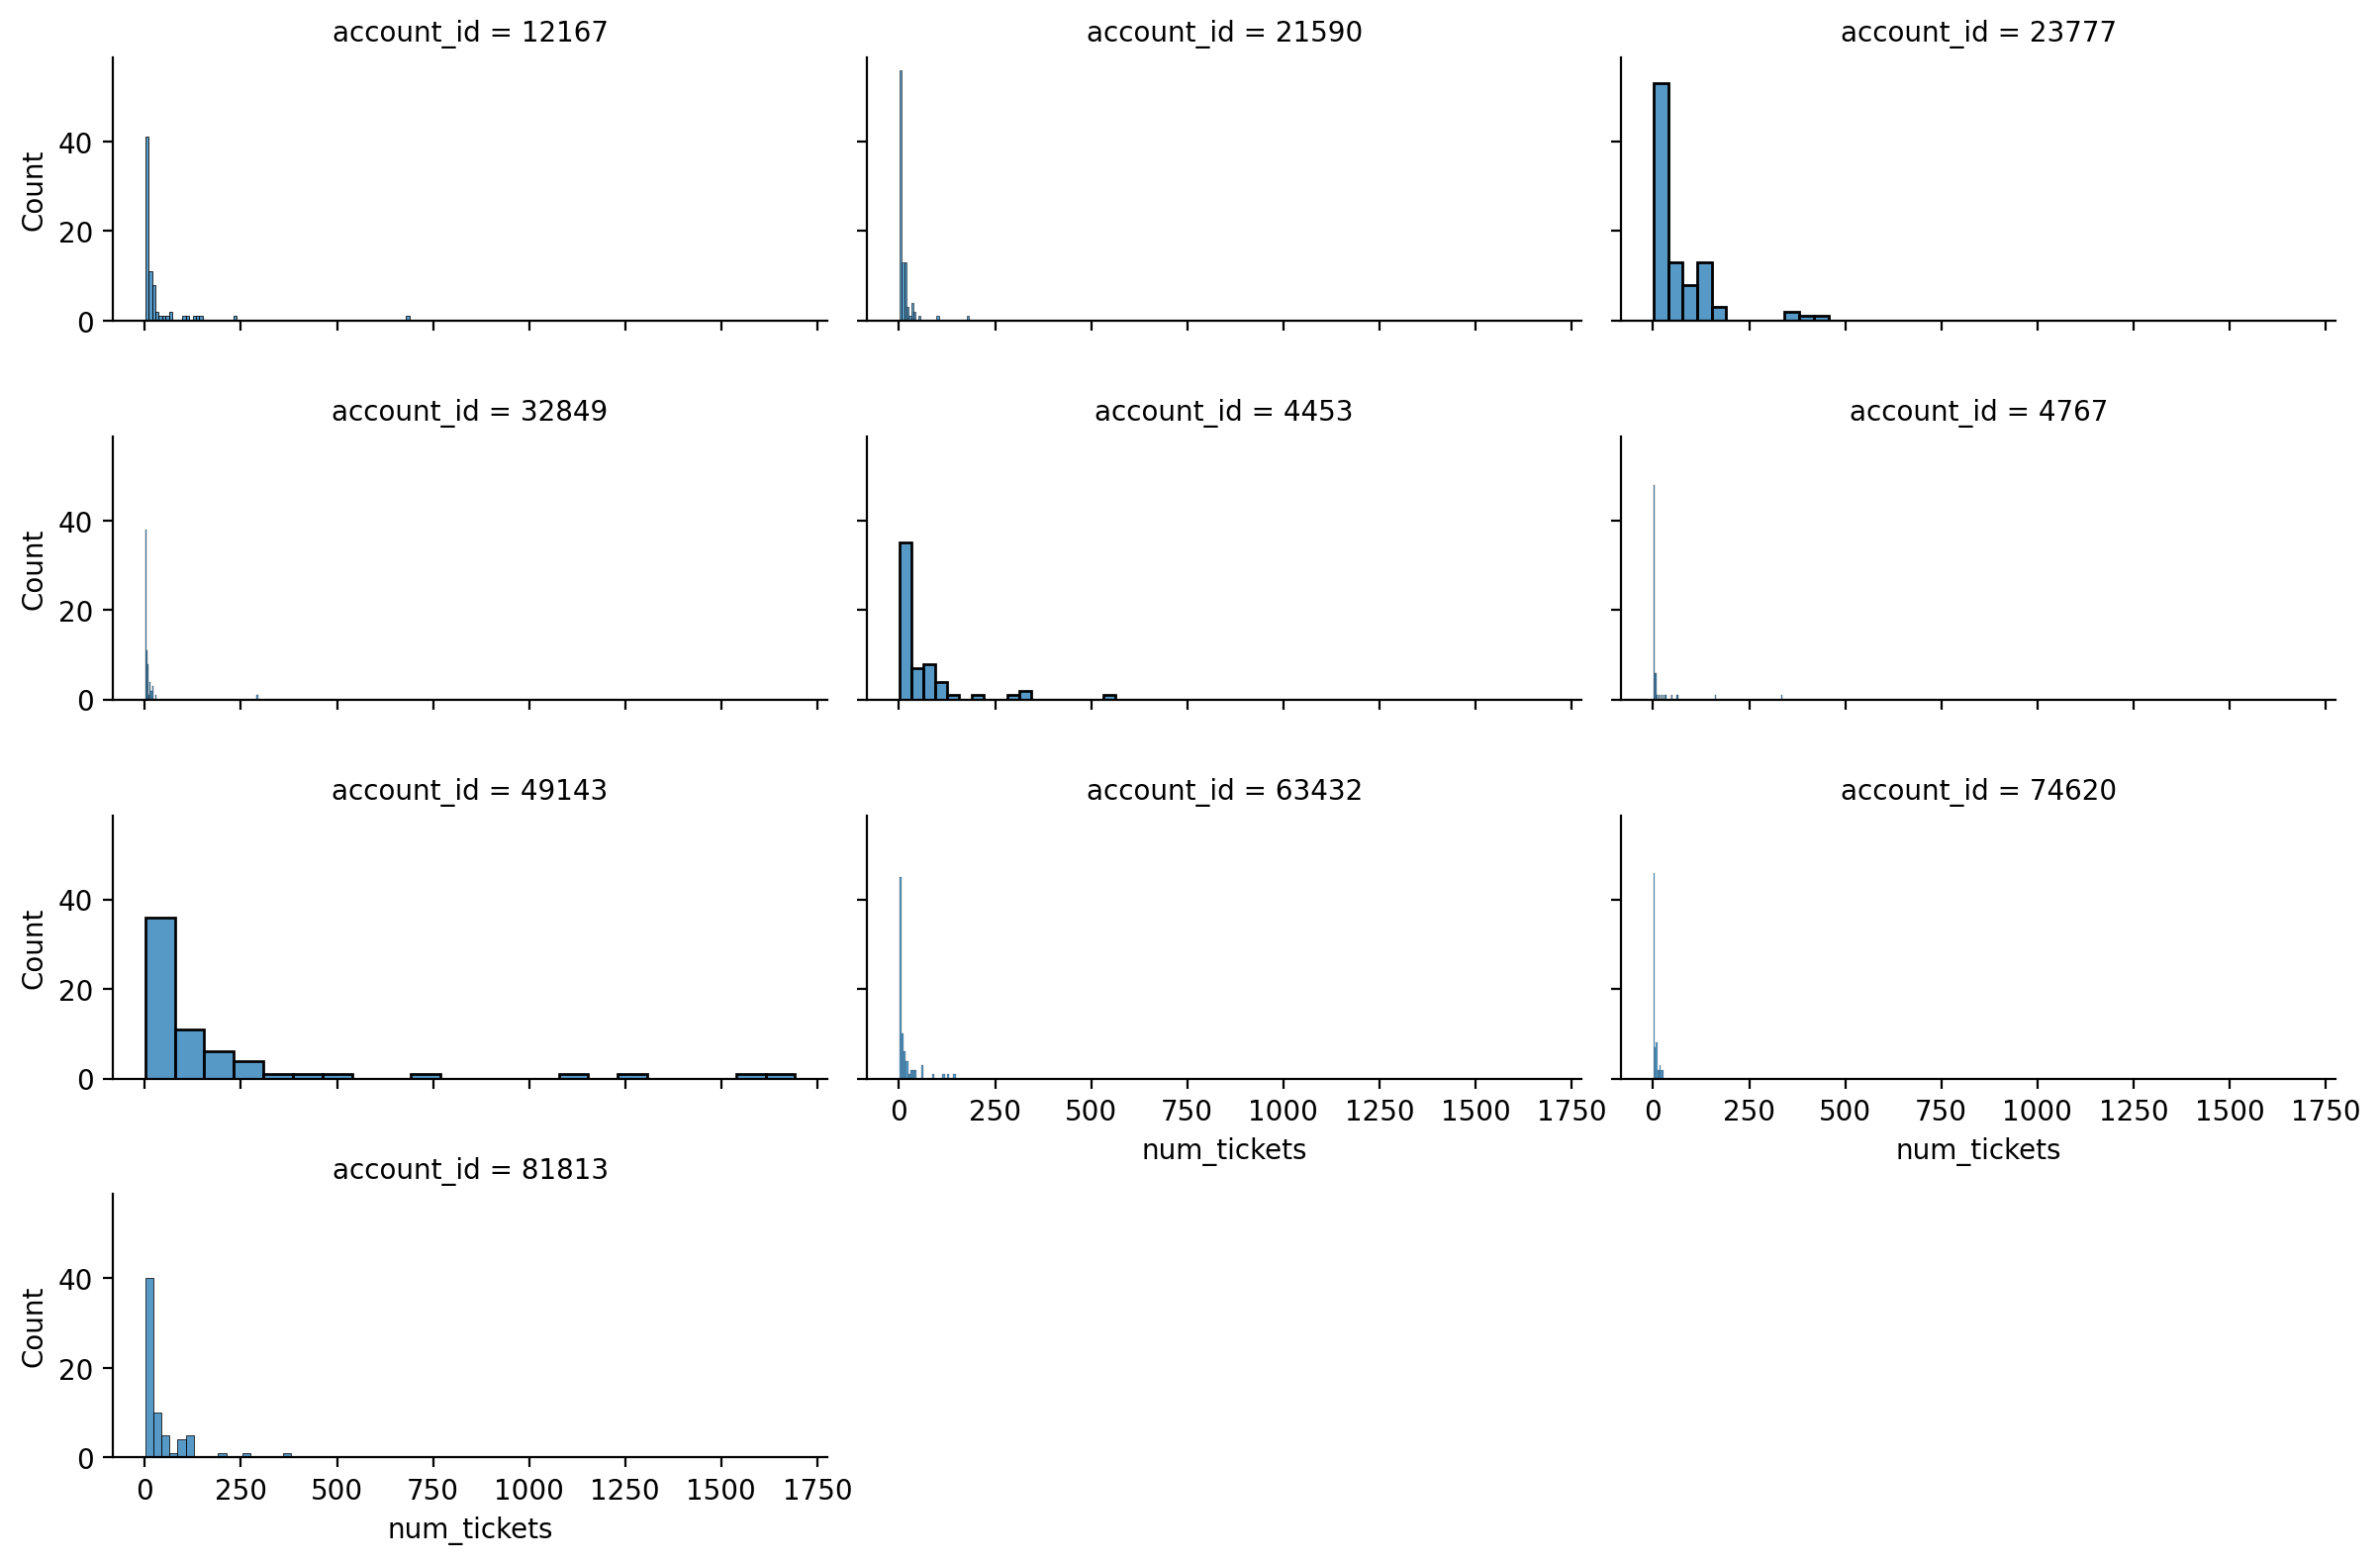

In [25]:
g = sns.FacetGrid(data=client_label_agg_cnt[client_label_agg_cnt.account_id.isin(top_client_ids[::-1])], 
                  col="account_id", col_wrap=3, aspect=2, height=2)
g.map(sns.histplot, "num_tickets")
plt.show()

The distribution of the number of tickets per contact reason is skewed for all top10 merchants. Due to the nature of ticket requests data, very few of them are quite frequent and the rest of them just happens very rare.

In [26]:
client_label_agg_cnt[client_label_agg_cnt.num_tickets <= 10].account_id.unique().shape[0]

66

Almost 99% of merchants have less than or equal to 10 tickets per contact reason and it seems quite interesting to handle them if possible in a PoC.

In [27]:
client_label_agg_cnt.sort_values("num_tickets", ascending=False).head(15)

account_id                 contact_reason  num_tickets
925       49143         "PDF::Poor On Arrival"         1692
944       49143        "WISMO::Not Despatched"         1587
923       49143   "PDF::Failed After Planting"         1289
940       49143             "WISMO::Delivered"         1140
945       49143            "WISMO::On the way"          713
458       32461                        "Other"          692
22        12167                          "N/A"          688
1834      89195                       "Return"          633
1836      89195              "Shipping::WISMO"          614
737        4453                        "Other"          563
917       49143  "No Response Needed (Triage)"          534
195       23353                         "Spam"          522
1830      89195                        "Order"          506
247       23777   "Cancel Request:: No reason"          456
328       23777  "Subscription:: Swap Product"          398

Top 10 popular contact reasons per merchant. Amongh those reasons we observe labels such as "Other", "N/A" and "Spam" that are not specific.

In [28]:
client_label_agg_cnt.sort_values("num_tickets", ascending=False).tail(10)

account_id                      contact_reason  num_tickets
1439      70399         "Order::Shipping inquiries"            1
1444      70399                   "Payment::Refund"            1
624       37330     "Shipping::Lost Shipment::USPS"            1
1446      70399       "Payment::Shopify Chargeback"            1
1448      70399                  "Product::Inquiry"            1
1449      70399                  "Product::Testers"            1
1450      70399                "Return::DHL return"            1
1451      70399                "Review::Trustpilot"            1
1454      70399  "Tracking::Delivered not received"            1
1933      92372           "Support::Rewards/Points"            1

Contact reasons with very few tickets per merchant.

In [29]:
label_stats = client_label_agg_cnt.groupby("account_id")["num_tickets"].describe() \
                                  .sort_values("count", ascending=False)

In [30]:
label_stats.sample(10)

count       mean         std   min    25%   50%    75%    max
account_id                                                               
4767         73.0  13.917808   44.493680   1.0   1.00   2.0   6.00  337.0
52904        21.0  16.000000   19.786359   1.0   3.00   8.0  20.00   66.0
81727        10.0   3.900000    3.984693   1.0   1.25   2.5   3.75   13.0
57130         9.0  54.444444   39.940929  10.0  30.00  54.0  69.00  141.0
4453         60.0  57.966667  100.222966   1.0   5.00  14.0  68.50  563.0
50159        19.0  47.263158   84.312805   1.0   8.50  17.0  38.50  366.0
79703        19.0  20.684211   27.792990   2.0   5.00   9.0  27.00  114.0
31286        32.0  19.656250   27.277084   1.0   3.00   8.0  19.00  115.0
61061        46.0  26.804348   42.261419   1.0   5.00  13.0  28.75  256.0
91003        26.0   3.192308    3.334897   1.0   1.00   2.0   4.00   13.0

Sample list of target distribution statistics per client.

In [31]:
label_stats[label_stats["75%"] <= 10].shape[0]

33

Almost half of the merchants have only a 25% of the number of labels having more than 10 tickets.

They have extremely skewed distribution of labels and it also a challenge to address that.

## Contact reason hierarchy structure

In [32]:
target_levels = df.contact_reason.apply(lambda x: x.replace('"', '').lower().split('::'))

In [33]:
target_levels.apply(lambda x: len(x)).max()

4

There are 4 levels at most in hierarchy structure of the contact reasons for all merchants.

In [34]:
df["contact_reason_lvl1"] = target_levels.apply(lambda x: x[0])
df["contact_reason_lvl2"] = target_levels.apply(lambda x: x[1] if len(x) > 1 else None)
df["contact_reason_lvl3"] = target_levels.apply(lambda x: x[2] if len(x) > 2 else None)
df["contact_reason_lvl4"] = target_levels.apply(lambda x: x[3] if len(x) > 3 else None)

In [35]:
print("Number of unique contact reasons in level1:", 
      df.contact_reason_lvl1.unique().shape[0], 
      "\nExamples: ", df.contact_reason_lvl1.value_counts().head(10).index.values, "\n")
print("Number of unique contact reasons in level2:", 
      df.contact_reason_lvl2.unique().shape[0], 
      "\nExamples: ", df.contact_reason_lvl2.value_counts().head(10).index.values, "\n")
print("Number of unique contact reasons in level3:", 
      df.contact_reason_lvl3.unique().shape[0], 
      "\nExamples: ", df.contact_reason_lvl3.value_counts().head(10).index.values, "\n")
print("Number of unique contact reasons in level4:", 
      df.contact_reason_lvl4.unique().shape[0], 
      "\nExamples: ", df.contact_reason_lvl4.value_counts().head(10).index.values, "\n")

Number of unique contact reasons in level1: 506 
Examples:  ['wismo' 'pdf' 'other' 'post-purchase' 'order' 'shipping' 'spam' 'return'
 'cancel request' 'subscription'] 

Number of unique contact reasons in level2: 871 
Examples:  ['poor on arrival' 'not despatched' 'return' 'failed after planting'
 'delivered' 'wismo' 'other' 'on the way' ' other' 'aftersales'] 

Number of unique contact reasons in level3: 379 
Examples:  ['other' 'return request' 'general product info/inquiry'
 'exchange request' 'defect' 'no longer needed' 'damage/defect' 'bedding'
 'general inquiry on order status' 'evri'] 

Number of unique contact reasons in level4: 44 
Examples:  ['dhl' 'usps' 'within week' 'in-state' 'missing item' 'fedex' 'same day'
 'womens' 'no vcare coverage' 'other'] 



So after splitting the contact reason into hierarchy levels the number of labels per level reduced significantly.

Moreover, let's take a look at the distribution of the number of unique contact reasons per level for a couple of the top merchants.

In [36]:
def print_hierarchy_level_info(account_id):
    """
    Print information about the hierarchy level of the merchant.
    param: account_id: id of merchant
    """

    merchant_data = df[df.account_id == account_id]

    print("Distribution of contact reasons per level for merchant: ", account_id, "\n")
    print("Number of unique contact reasons:", merchant_data.contact_reason.unique().shape[0])
    print("Number of unique contact reasons in level1:", 
        merchant_data.contact_reason_lvl1.dropna().unique().shape[0], 
        "\nExamples: ", merchant_data.contact_reason_lvl1.value_counts().head(5).index.values, "\n")
    print("Number of unique contact reasons in level2:", 
        merchant_data.contact_reason_lvl2.dropna().unique().shape[0], 
        "\nExamples: ", merchant_data.contact_reason_lvl2.value_counts().head(5).index.values, "\n")
    print("Number of unique contact reasons in level3:", 
        merchant_data.contact_reason_lvl3.dropna().unique().shape[0], 
        "\nExamples: ", merchant_data.contact_reason_lvl3.value_counts().head(5).index.values, "\n")
    print("Number of unique contact reasons in level4:", 
        merchant_data.contact_reason_lvl4.dropna().unique().shape[0], 
        "\nExamples: ", merchant_data.contact_reason_lvl4.value_counts().head(5).index.values, "\n")

In [37]:
print_hierarchy_level_info(top_client_ids[-1])
print("------------")
print_hierarchy_level_info(top_client_ids[0])

Distribution of contact reasons per level for merchant:  21590 

Number of unique contact reasons: 95
Number of unique contact reasons in level1: 27 
Examples:  ['return/exchange' 'cx initiated' 'delivery/shipping'
 'spam/non-support-related' 'damage/defect'] 

Number of unique contact reasons in level2: 69 
Examples:  ['judge.me' 'general questions' 'package missing/lost'
 'manufacturing defect' 'rewards >> how to redeem'] 

Number of unique contact reasons in level3: 0 
Examples:  [] 

Number of unique contact reasons in level4: 0 
Examples:  [] 

------------
Distribution of contact reasons per level for merchant:  4453 

Number of unique contact reasons: 60
Number of unique contact reasons in level1: 6 
Examples:  ['post-purchase' 'other' 'presale' 'amazon' 'external channel'] 

Number of unique contact reasons in level2: 15 
Examples:  ['return' 'shipping' 'other' 'change order' 'product inquiry'] 

Number of unique contact reasons in level3: 34 
Examples:  ['return request' 'othe

The number of classes per level drops significantly compared to the total number of unique contact reasons per merchant. 

Given that information it drives to an idea to approach hierarchical classification and build a classification model per level for each merchant.

## Email sentence embeddings info

In [38]:
df.email_sentence_embeddings.isnull().sum()

5453

In [39]:
round(5453/df.shape[0] * 100, 1)

9.7

The data shows 5453 (~10%) missing sentence embeddings across the client tickets.

In [40]:
embed_missing_stats = pd.concat([
    df.groupby("account_id").email_sentence_embeddings \
                            .size() \
                            .to_frame("embeddings_cnt_per_client"),
    df.groupby("account_id").email_sentence_embeddings \
                            .apply(lambda x: round(x.isnull().sum() / x.shape[0] * 100, 1)) \
                            .sort_values(ascending=False) \
                            .to_frame("missing_pct_of_embeddings_per_client")
], axis=1).sort_values("missing_pct_of_embeddings_per_client", ascending=False)

In [41]:
embed_missing_stats.head(10)

embeddings_cnt_per_client  missing_pct_of_embeddings_per_client
account_id                                                                 
90756                               1                                 100.0
85684                              45                                 100.0
65210                            1429                                  70.5
88689                               2                                  50.0
68999                             635                                  45.4
57130                             490                                  41.2
45491                              79                                  40.5
62530                               7                                  28.6
11539                             214                                  26.6
57151                               4                                  25.0

Merchants **90756** and **85684** do not have any email sentence embeddings at all.

What are the **common contact reasons** having missing sentence embeddings?

In [42]:
client_ids = embed_missing_stats[embed_missing_stats.missing_pct_of_embeddings_per_client >= 50.].index.tolist()
top_missing_labels =  df[df.account_id.isin(client_ids)].contact_reason.value_counts().to_frame("cnt")

In [43]:
top_missing_labels.head(10)

cnt
contact_reason                         
"Misc::Spam"                        304
"Returns::Return Label"             112
"Existing Order::WISMO"             109
"Existing Order::Change/Cancel"     100
"Store Message::QAS"                 83
"Subscription::Cancel"               60
"Existing Order::Price Adjust"       57
"Store Message::Customer Question"   49
"Store Message::Training"            48
"Pre-Sale::Discount"                 47

In [44]:
df["ticket_datetime"] = pd.to_datetime(df.unix_timestamp.apply(lambda x: datetime.fromtimestamp(x)))

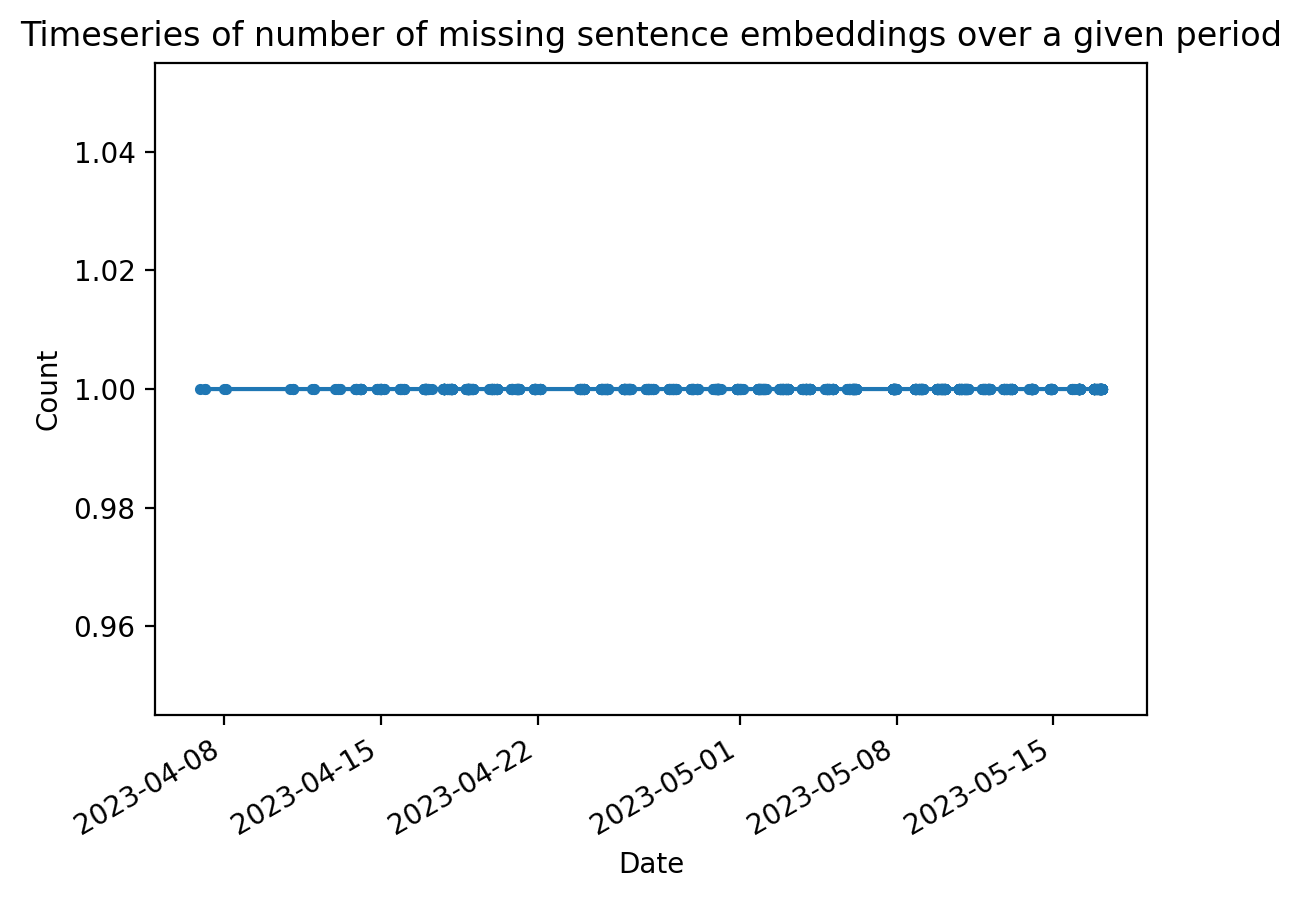

In [45]:
df[df.account_id.isin(client_ids)].ticket_datetime.value_counts().plot(marker=".")
plt.title("Timeseries of number of missing sentence embeddings over a given period")
plt.ylabel("Count")
plt.xlabel("Date")
plt.show()

The missing embeddings distributed quite uniformly over a given period.

The list of contact reasons with missing sentence embeddings might signal about the following issues:
- Ticket is represented as an empty email
- Technical failure in the ticket support system
- Tickets are affected by development or integration processes in the system.

We might ignore them while training a model or build a model to impute the missing embeddings for the tickets. One of the candidate model is vanilla k nearest neighbours (kNN).

In [50]:
df["email_sentence_embeddings"] = df.email_sentence_embeddings.apply(lambda x: json.loads(x) if x else None)
df["email_sentence_len"] = df.email_sentence_embeddings.apply(lambda x: len(x) if x else None)
df["email_sentence_hashed"] = df.email_sentence_embeddings.apply(lambda x: ''.join([key for key in x]) if x else None)

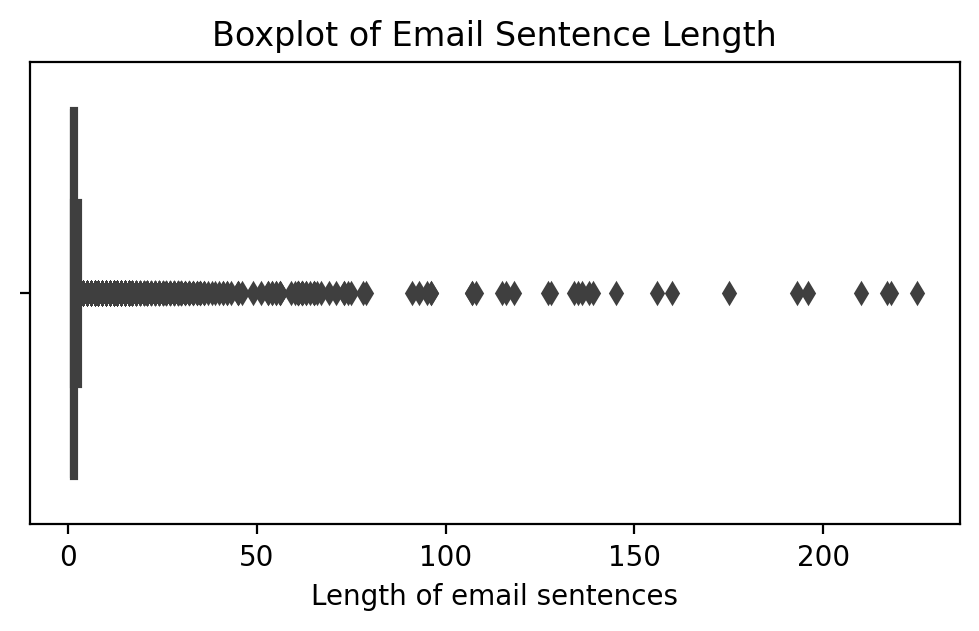

In [48]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=df.email_sentence_len.dropna().astype(int))
plt.title("Boxplot of Email Sentence Length")
plt.xlabel("Length of email sentences")
plt.show()

In [49]:
df.email_sentence_len.describe().apply(lambda x: round(x, 1)).to_frame()

email_sentence_len
count             50719.0
mean                  2.3
std                   4.8
min                   1.0
25%                   1.0
50%                   1.0
75%                   2.0
max                 225.0

- 75% of tickets have at most 2 sentences and half population of tickets have only one embedding.

- There are a couple of ideas to wrap up the multiple embeddings of the tickets onto a single one to preserve the embedding dimension (in this case is 384):
  - averaging or mean pooling the features of every dimension to get the essence of all the sentences in the ticket.
  - max pooling the features of every dimension to focus on most important features of all the sentences in the ticket.

In [54]:
def tsne_reduction_and_plot_embeddings(embeddings, labels, id_list=None, title="", label_name=""):
    """
    TSNE reduction and plot embeddings.
    :param embeddings: pretrained feature vectors
    :param labels: target variable
    :param id_list: list of ids to slice the data for visualization
    :param title: title of the plot
    :param label_name: name of the target variable in the plot
    :return:
    """
    # Learn embeddings.
    print("Learning embeddings")
    np.random.seed(42)
    model = TSNE(n_components=2, random_state=42)
    embedded = model.fit_transform(embeddings)

    # Plot embeddings.
    print("Plotting")
    embedded_df = pd.DataFrame(embedded)
    embedded_df.columns = ["x", "y"]
    embedded_df[label_name] = labels

    viz_data = embedded_df[embedded_df[label_name].isin(id_list)] if id_list else embedded_df
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x="x", y="y", hue=label_name, data=viz_data)
    plt.title(title)
    plt.show()

In [55]:
mean_pooled_embeddings = df.set_index("account_id").email_sentence_embeddings \
                           .apply(lambda x: np.mean([emb for _, emb in x.items()], axis=0) if x else None) \
                           .dropna()
max_pooled_embeddings = df.set_index("account_id").email_sentence_embeddings \
                          .apply(lambda x: np.max([emb for _, emb in x.items()], axis=0) if x else None) \
                          .dropna()

Learning embeddings
Plotting


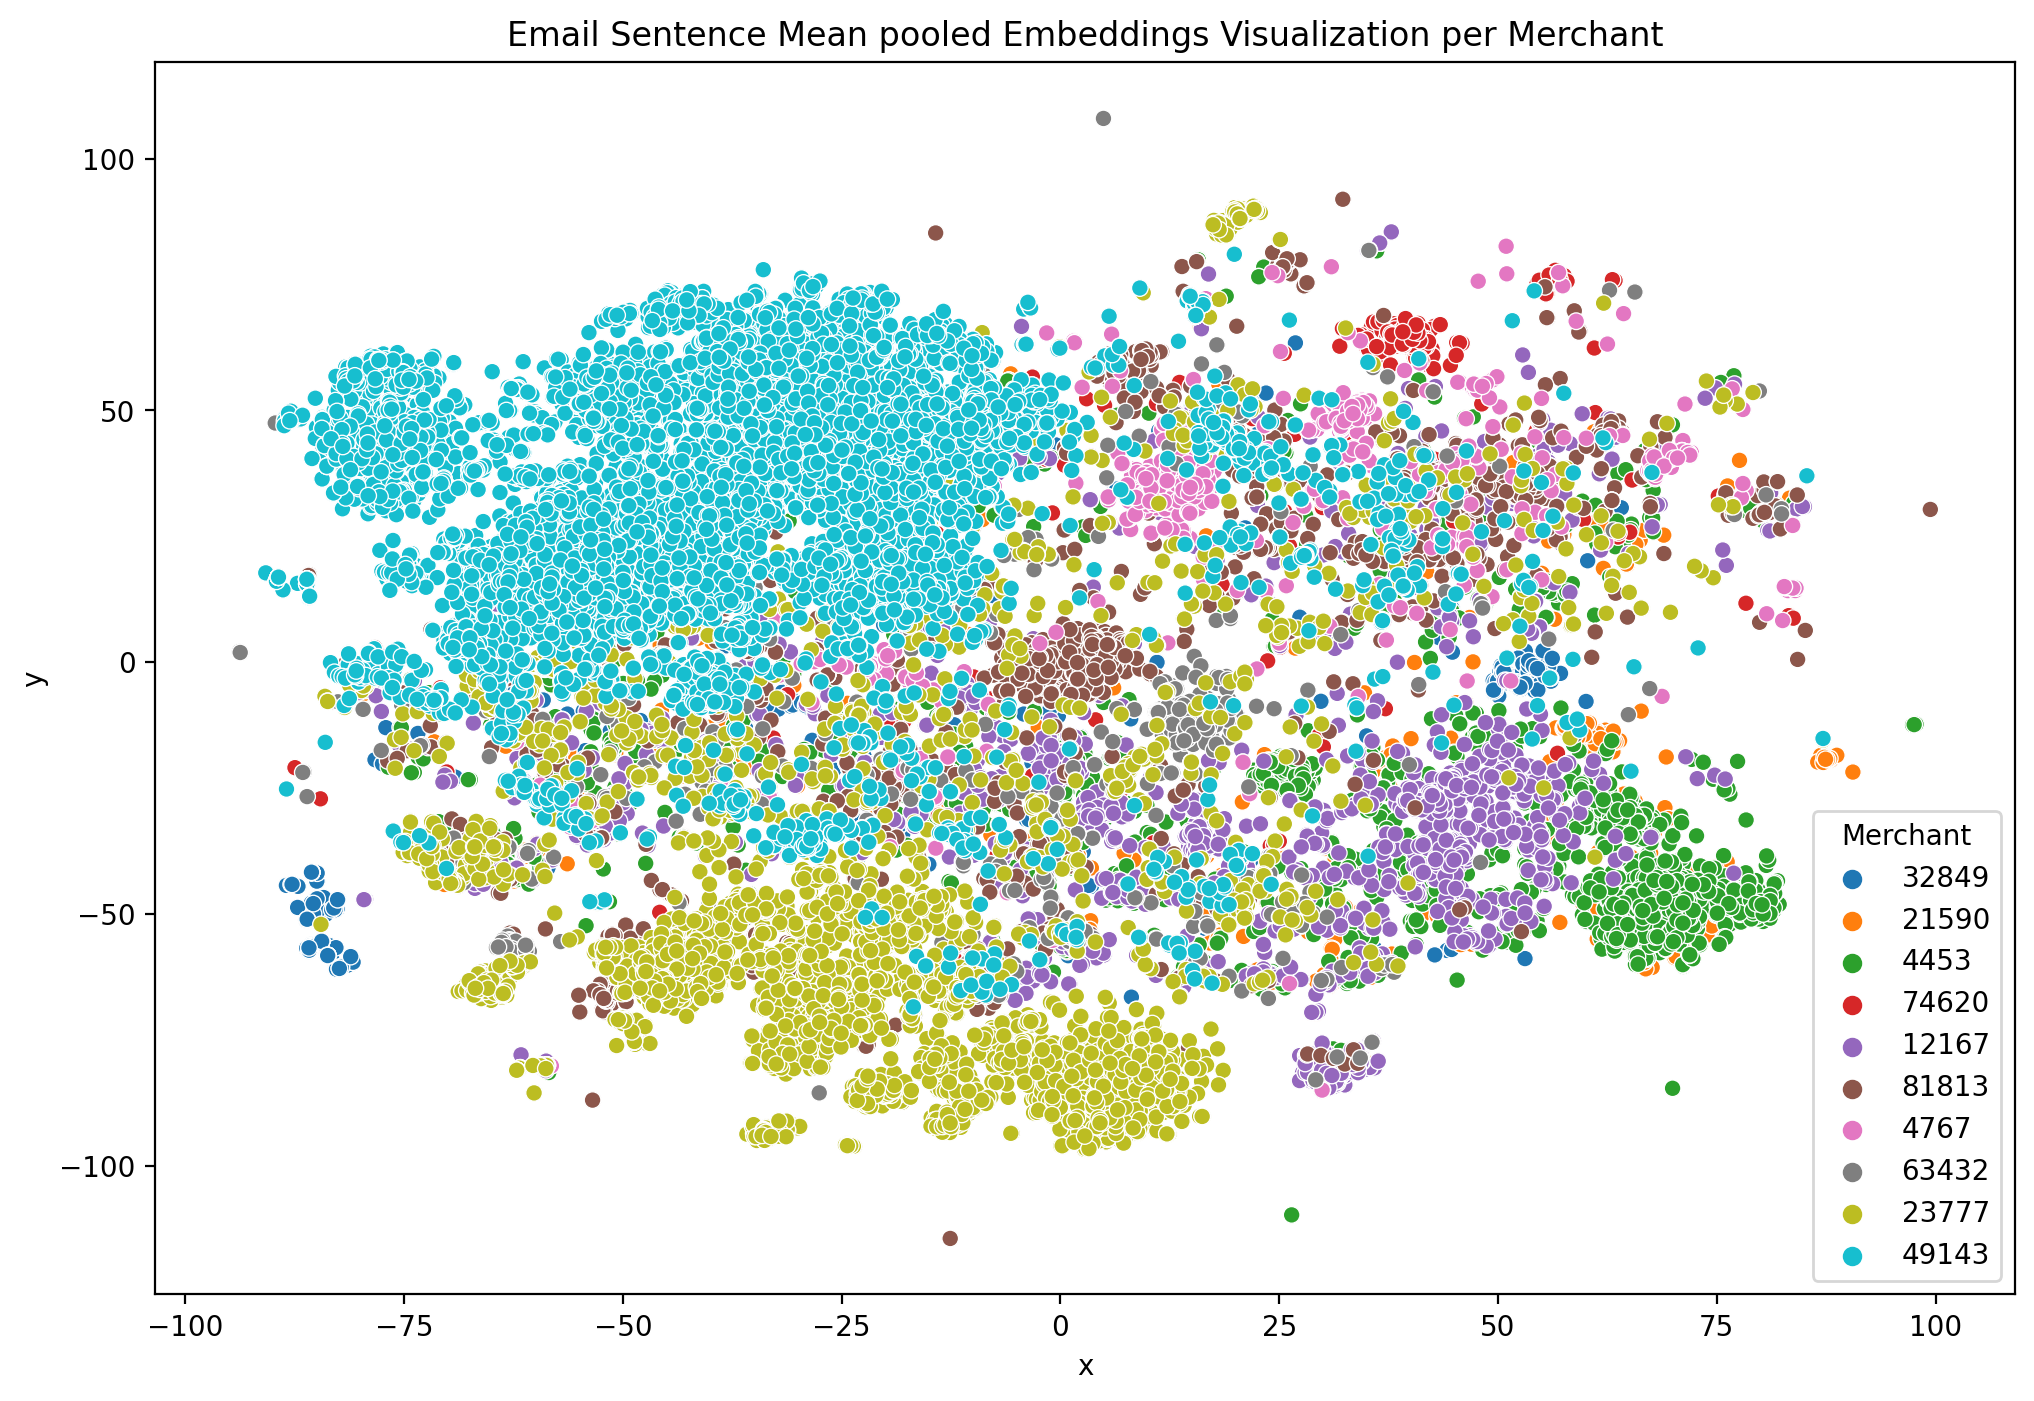

In [56]:
labels, embeddings = mean_pooled_embeddings.index.values, np.array([vec.tolist() for vec in mean_pooled_embeddings.values])
tsne_reduction_and_plot_embeddings(embeddings, labels, top_client_ids,
                                   "Email Sentence Mean pooled Embeddings Visualization per Merchant", "Merchant")

- The plot shows reduced 2d vector representations of mean pooled sentence embeddings. 

- As per observation for top 10 merchants in the data, majority of the embeddings are client specific and rest of them are spreaded accross.

Learning embeddings
Plotting


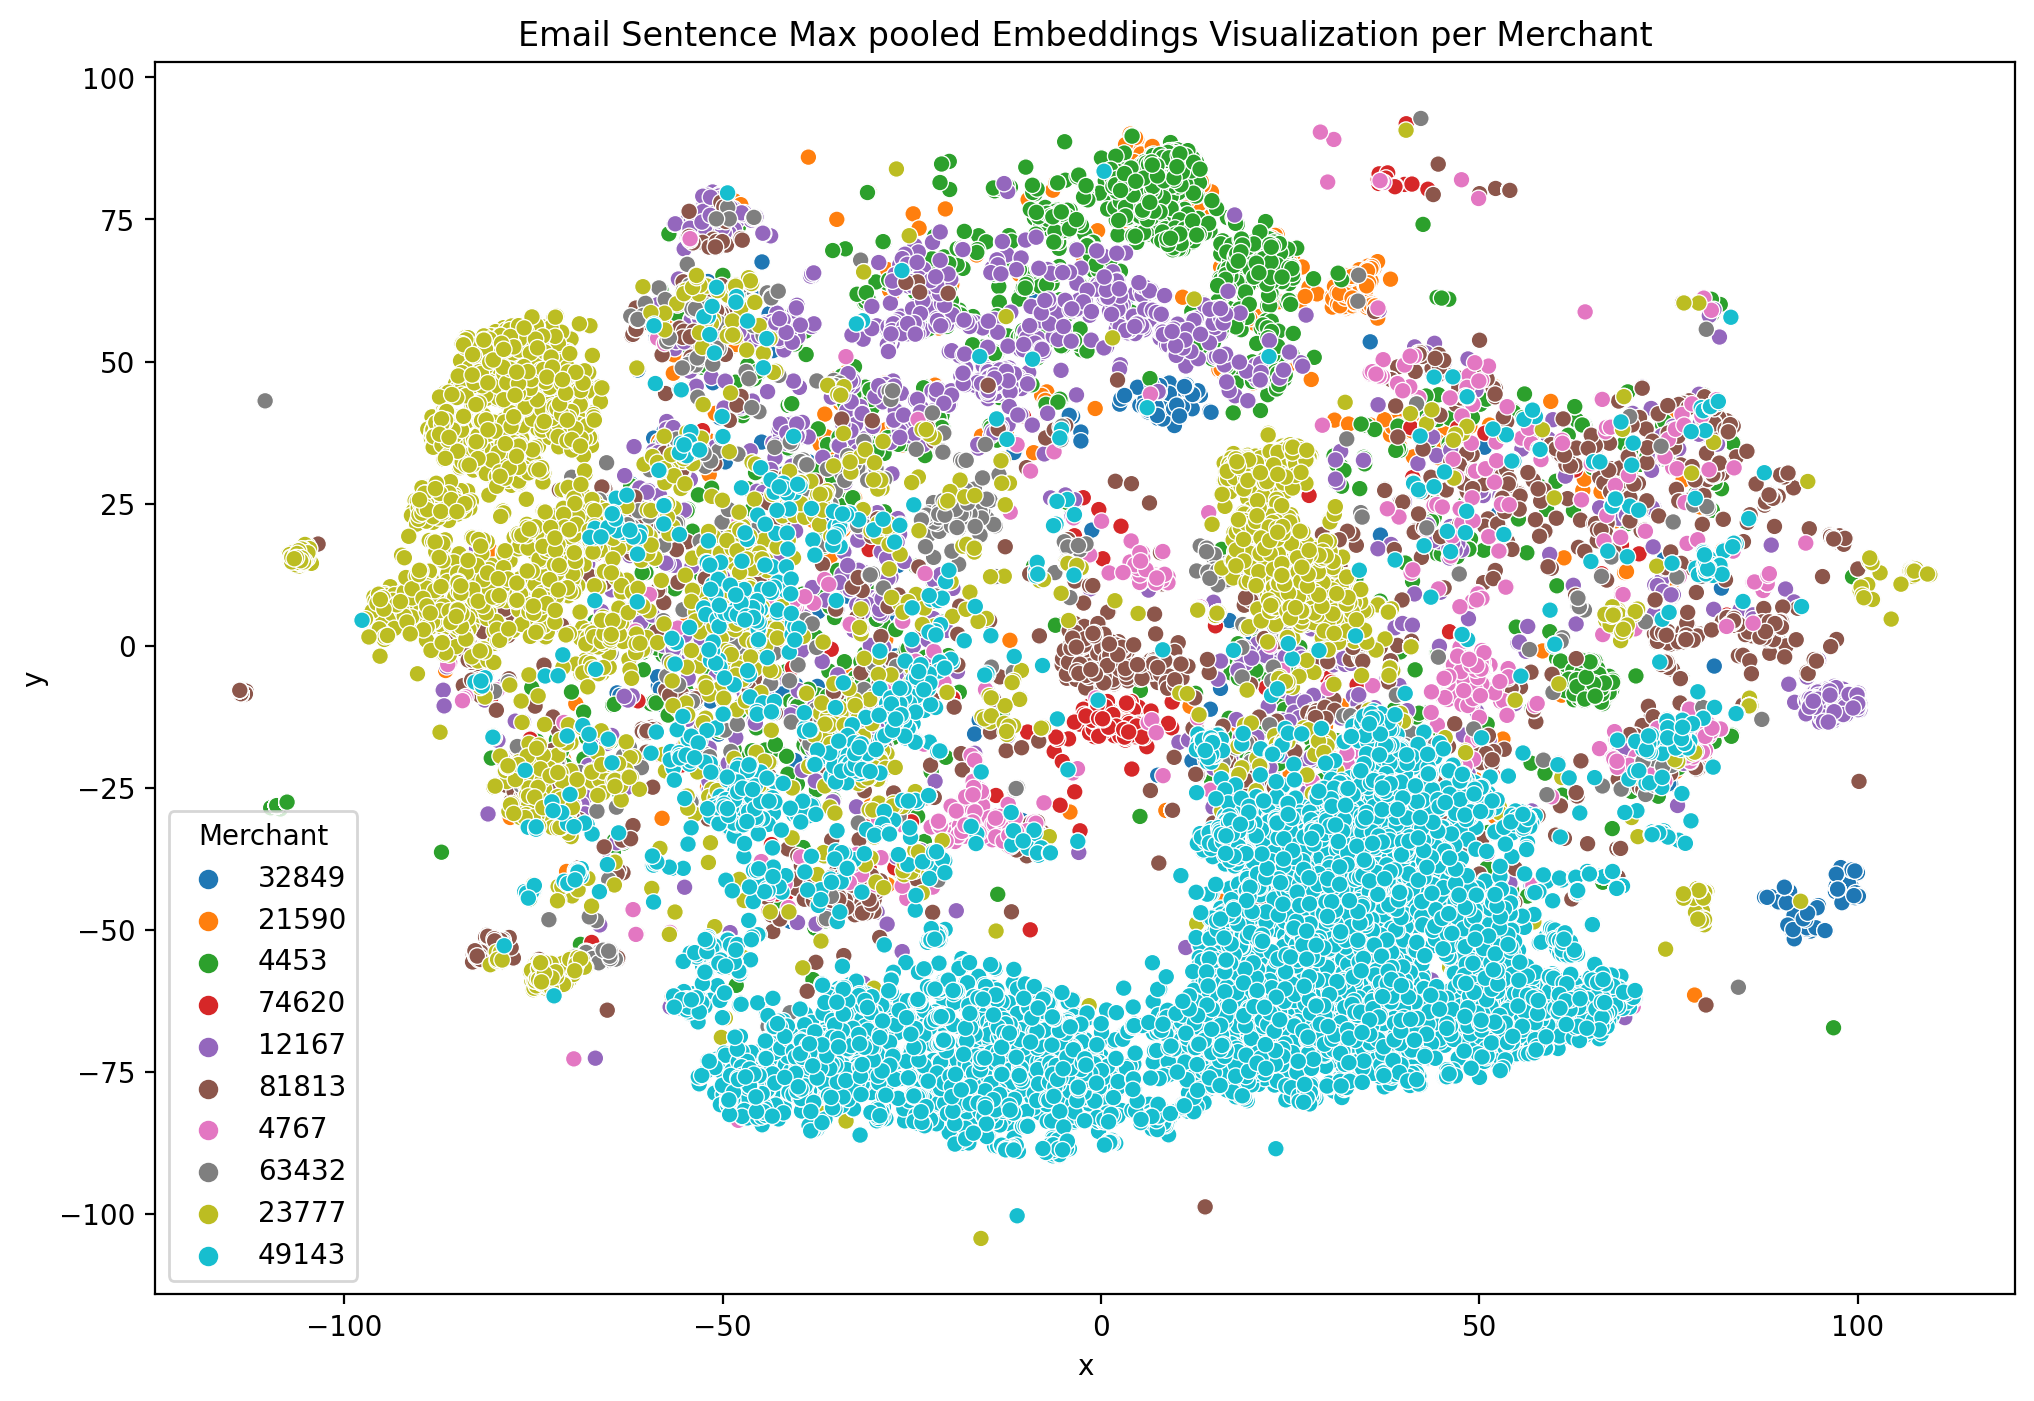

In [57]:
labels, embeddings = max_pooled_embeddings.index.values, np.array([vec.tolist() for vec in max_pooled_embeddings.values])
tsne_reduction_and_plot_embeddings(embeddings, labels, top_client_ids,
                                   "Email Sentence Max pooled Embeddings Visualization per Merchant", "Merchant")

- The plot shows reduced 2d vector representations of max pooled sentence embeddings. 

 - As per observation the sentence embeddings are more distinct and specific to merchant.

## Explore email sentences having multiple contact reasons

In [82]:
label_sentence_agg = df.groupby("email_sentence_hashed").contact_reason \
                       .apply(lambda x: set(x)) \
                      .to_frame("contact_reason_set").reset_index()
label_sentence_agg["contact_reason_set_len"] = label_sentence_agg.contact_reason_set.apply(lambda x: len(x))

In [95]:
label_sentence_agg[label_sentence_agg.contact_reason_set_len > 1].sort_values("contact_reason_set_len", ascending=False)

email_sentence_hashed   
41643                                6858949963305073315  \
5660                                -2930830737690885852   
30002                                2839169995055242806   
47464                                8844789218706559610   
20076                               -7756397586158252975   
...                                                  ...   
18330                               -7167049517083517319   
18884              -735446040269649558980340182767128214   
19223                               -7474816849114855937   
19327           -7509758838431835580-9130952435586830733   
48627  930192822789373983-533025232367051806-82066035...   

                                      contact_reason_set   
41643  {"Cancel Order", "Delivered but never received...  \
5660   {"Cancel Request:: I don't want a subscription...   
30002  {"Warranty", "Fulfillment", "Pre-Sales", "Ship...   
47464  {"Customer::Purchase Query", "Orders::Changes ...   
20076  {"Cancel Request:: No reason", "Subscription C...   
...                                                  ...   
18330                 {"Product Information", "Restock"}   
18884  {"PDF::Failed After Planting", "PDF::Poor On A...   
19223                              {"Restock", "Return"}   
19327                      {"Other", "Returns :: Query"}   
48627  {"Not-Support-Related::Spam/Solicitation", "No...   

       contact_reason_set_len  
41643                      50  
5660                        8  
30002                       6  
47464                       5  
20076                       5  
...                       ...  
18330                       2  
18884                       2  
19223                       2  
19327                       2  
48627                       2  

[194 rows x 3 columns]

In [93]:
round((label_sentence_agg.contact_reason_set_len > 1).sum() / label_sentence_agg.shape[0] * 100, 1)

0.4

In [ ]:
df[df.email_sentence_hashed == "6858949963305073315"].contact_reason.value_counts().head(10)

contact_reason
"Missed call"            141
"Apply Promo"             50
"Where is my order?"      27
"Unknown Issue"           22
"Advice"                  22
"Return no reason"        16
"Edit Order"              13
"Damaged"                 12
"Product Question"        12
"Wrong Item Received"     11
Name: count, dtype: int64

In [ ]:
df[df.email_sentence_hashed == "-2930830737690885852"].contact_reason.value_counts()

contact_reason
"Order Support::Cancel::No longer needed"         8
"Cancel Request:: No reason"                      7
"Cancel Request:: Other"                          2
"Subscription Cancelation"                        1
"Order Support::Refunds::Refund request"          1
"Customer::Subscription Change"                   1
"Customer::Cancellation Request"                  1
"Cancel Request:: I don't want a subscription"    1
Name: count, dtype: int64

- Some of the email sentences have multiple contact reasons, however they only comprise a less than percent of the total population of sentences.

- In addition to that, email sentences having more than one class can be considered under multi-label classification approach.

# Summary

To summarize, there are a list of key points gathered from EDA:
- As the merchants have unique set of contact reasons the idea is to build a Machine Learning (ML) solution per merchant as well. So the current approach is flexible, adaptable and scalable.
  
- As the number of classes varies significantly and some classes have a few number of tickets for building a classification model, the hierarchical approach could address that issue and consolidate an infrequent classes into bigger ones and get rid of sparse combinations.
  
-  The email sentence embeddings are merchant specific so it solidifies the idea to build individual ML solution for each merchant.